# 폐렴 진단을 위한 CNN 성능 개선 프로젝트(ft. ResNet-18)

## 개요 (Overview)
이번 프로젝트에서는 흉부 x-ray 이미지를 활용해 폐렴을 진단하는 CNN 베이스 모델을 구축하고 
데이터 증강과 모델 구조 변화를 통해  모델 성능을 개선한다. 

## 프로젝트 목표
1. 의료영상을 처리하는 CNN 기반 베이스 모델을 구현
2. 모델 구조 변경으로 성능 비교
3. Data Augmentation 기법으로 성능 비교
4. ResNet-18 모델을 이해하고 활용
->  이번 실험과정에서 데이터증강에 대한 효과를 더 첨예하게 확인하고자
   모델구조 변경으로 성능 비교를 우선 실행하여 최종적으로 실험결과 값이 최상인 
   모델을 찾고, 그 모델에서 데이터 증강을 적용하고 비교했습니다. 
    또한, 클래스 가중치가 갖는 의미를 확인하기 위해 클래스 가중치와 같은 기본설정도    베이스라인에서는 제외하고 비교항목으로 설정하였습니다. 


## 목차
1. 실험환경 Set-up    
  
2. 데이터 준비  
    2-1. 테이터 경로설정과 파일목록 생성  
    2-2. 데이터 분할  
    2-3. 정상:폐렴 개수 파악  
    2-4. Train:Validation 데이터 개수 파악  
    2-5. 데이터 Labeling  
    2-6. Data Set 생성  
    2-7. 데이터 준비 함수  
    2-8. 데이터 이미지 시각화   
          
3. ResNet-18 베이스 모델 구현    
    3-1. Residual block 구성   
    3-2. ResNet-18 모델 정의   
    3-3. 모델 Complie  
    3-4. 베이스 모델 학습 및 평가  
    3-5. 베이스 모델 성능 시각화  

4. 모델 구조 변경 및 성능 비교  
    4-1. 콜백 정의(기본콜백)  
    4-2. 클래스 가중치 적용  
         4-2-1. 클래스 가중치 적용 모델 학습  
         4-2-2. 클래스 가중치 적용 모델 비교 평가  
    4-3. 학습률과 배치 사이즈 조정  
         4-3-1. 학습률 조정  
         4-3-2. 배치 사이즈 조정  
    4-4. 클래스 가중치 재조정  
    4-5. Dropout Layer 추가  
  
5. 데이터 증강에 따른 성능 비교  
    5-1. 데이터 증강 기법 적용  
    5-2. 강화된 데이터 증강과 클래스 가중치 재조정

## 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

BATCH_SIZE = 32  # 배치 크기 32로 상향
EPOCHS = 20      # 에포크 수 20으로 상향


## 2. 데이터 준비

2-1. 테이터 경로설정과 파일목록 생성

In [2]:
# 데이터 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 데이터 파일 목록 생성
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f"train_data : {len(train_filenames)}")
print(f"val_data : {len(val_filenames)}")
print(f"test_data : {len(test_filenames)}")

train_data : 5216
val_data : 16
test_data : 624


2-2. 데이터 분할 (train : val = 8 : 2)

In [3]:
# train_data와 val_data를 filenames 로 취합
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 분할
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


2-3. 정상 : 폐렴 개수 파악 = 정상(1072) : 폐렴(3113)

In [4]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


2-4. Train : Validation 데이터셋 개수 파악 = Train(4185) : Val(1047)

In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [6]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


2-5. 데이터 Labeling

In [7]:
# 파일 경로를 이용하여 라벨 추출
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  # 폐렴이면 양성(True), 정상이면 음성(False)

In [8]:
# 이미지 데이터 전처리 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력으로 이미지와 라벨을 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


2-6. Data Set 생성(train : val : test)

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
# Resizing과 Labeling 검토
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


2-7. 데이터 준비 함수

In [12]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

2-8. 데이터 이미지 시각화 

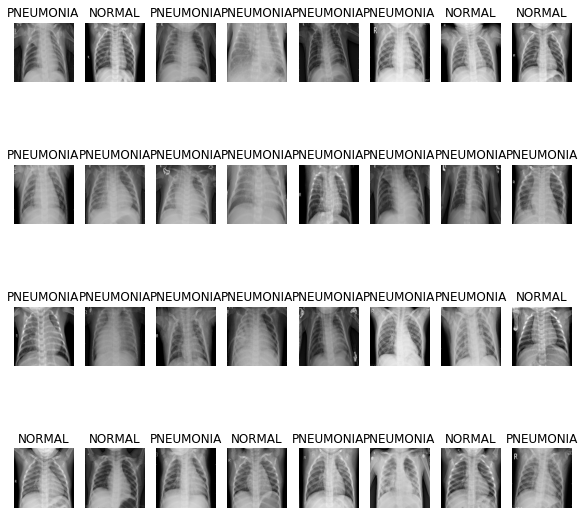

In [13]:
# 이미지 시각화 함수
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


## 3. ResNet-18 베이스 모델 구현

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, GlobalAveragePooling2D, Dense, MaxPooling2D

3-1. Residual block 구성 (3x3 CNN, BN, Relu + Skip Connection)

In [15]:
def residual_block(inputs, filters, strides=1):
    # weight layer 1
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # weight layer 2 (relu는 add 후에 적용)
    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Skip connection (identity)
    if strides != 1 or inputs.shape[-1] != filters:
        skip = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(inputs)
        skip = tf.keras.layers.BatchNormalization()(skip)
    else:
        skip = inputs

    # Add and apply ReLU
    x = tf.keras.layers.Add()([x, skip])
    x = tf.keras.layers.ReLU()(x)
    return x

3-2. ResNet-18 모델 정의 (Residual함수 정의와 연동해 총 18층 심층망 형성)

In [16]:
def build_model(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # conv1: 7×7, 64
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # 3×3 max pool
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # conv2_x: [3×3, 64]×2
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    # conv3_x: [3×3, 128]×2
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)
    
    # conv4_x: [3×3, 256]×2
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)
    
    # conv5_x: [3×3, 512]×2
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512)
    
    # 7×7 average pool
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layers (2×1000)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    
    # Output Layer
    outputs = tf.keras.layers.Dense(1, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [17]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 90, 90, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

3-3. 모델 Compile

In [18]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
              tf.keras.metrics.Recall(name='recall'),
              tf.keras.metrics.Precision(name='precision'),
    ]
)

3-4. 베이스 모델 학습

In [31]:
# repeat()에 대한 steps per epoch 설정
steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE
validation_steps = VAL_IMG_COUNT // BATCH_SIZE

# # 기본 학습 
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     verbose=1
# )

3-5. 베이스 모델 평가

In [20]:
# 수동으로 기록된 로그 데이터
epochs = [1, 2, 3, 4, 5, 6, 7]
train_loss = [0.0978, 0.0786, 0.0838, 0.0655, 0.0776, 0.0517, 0.0499]
val_loss = [1.1924, 0.9118, 2.6685, 4.9162, 0.1437, 0.6384, None]  # 마지막 에포크는 수동 중단
train_accuracy = [0.7437, 0.7433, 0.7452, 0.7425, 0.7430, 0.7450, 0.7440]
val_accuracy = [0.7354, 0.7363, 0.7373, 0.7324, 0.7324, 0.7354, None]

# 베이스 모델 평가 결과 출력
print("=== Base Model Evaluation ===")
print("\nTraining Metrics (Final):")
print(f"Loss: {train_loss[-1]:.4f}")
print(f"Accuracy: {train_accuracy[-1]:.4f}")
print(f"Recall: 1.0000")  # 모든 에포크에서 1.0
print(f"Precision: {train_accuracy[-1]:.4f}")  # precision과 accuracy가 동일

print("\nValidation Metrics (Best):")
# 마지막 None 제외하고 최소/최대값 계산
valid_losses = [v for v in val_loss if v is not None]
valid_accuracies = [v for v in val_accuracy if v is not None]
print(f"Loss: {min(valid_losses):.4f}")
print(f"Accuracy: {max(valid_accuracies):.4f}")
print(f"Recall: 1.0000")  # 모든 에포크에서 1.0
print(f"Precision: {max(valid_accuracies):.4f}")  # precision과 accuracy가 동일

print("\nOverfitting Analysis:")
print(f"Final Train-Val Loss Gap: {abs(train_loss[-2] - val_loss[-2]):.4f}")  # 마지막 완전한 에포크
print(f"Final Train-Val Accuracy Gap: {abs(train_accuracy[-2] - val_accuracy[-2]):.4f}")

=== Base Model Evaluation ===

Training Metrics (Final):
Loss: 0.0499
Accuracy: 0.7440
Recall: 1.0000
Precision: 0.7440

Validation Metrics (Best):
Loss: 0.1437
Accuracy: 0.7373
Recall: 1.0000
Precision: 0.7373

Overfitting Analysis:
Final Train-Val Loss Gap: 0.5867
Final Train-Val Accuracy Gap: 0.0096


### 베이스모델 학습 중간 점검 : Epoch 7에서 수동으로 정지
##### - Recall이 1.0상에서 변동없고 Precision 0.74로 정체 
의도적으로 클래스 가중치 조정을 베이스모델에서 제외했기에 데이터는 이미 폐렴이미지가 3배더 많은 편향을 가진 상태이고 1/3 적은 정상데이터를 마져도 Precision이 0.74로 애매한 위치에서 정체되었다는 것은 '정상을 폐렴으로 오분류'도 많았다는 의미. 
##### - Val_acc 0.74로 정체 
실질적인 학습이 잘 이루어지지 않음으로 판단
##### - Val_loss 매우 불안정한 패턴
현재 학습률보다 낮게 설정 실험해볼 필요성과 배치사이즈 조정, 정규화 과정 등을 통해 비교할 명목. 

### 이후 실험 계획
##### - 남은 에포크를 20까지 완성하고 반복에 따른 학습 변화 관찰
##### - Recall 수치가 우선적으로 다소 떨어지더라도 클래스 불균형 개선을 통해 데이터 편향을 먼저해결하고 결과 비교. 데이터 평준화 상태에서  각각의 수치를 다시 파악하고 베이스모델과 비교하겠다. Ver.2
##### - 그 후 순차적으로 과적합 개선을 위한 Learning Rate와 배치사이즈 조정 그리고 정규화 등을 시행하며 비교하고, 점진적으로 recall이 얼마나 개선될 수 있는지 관찰

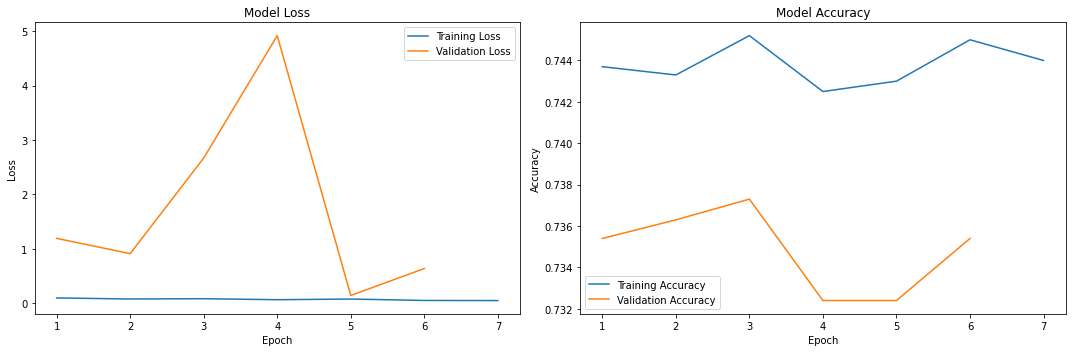

In [21]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### 베이스모델 에포크 20까지 마저 실행 후 결과 평가

In [22]:
# 베이스 모델 평가 결과 출력
print("=== Base Model Evaluation ===")
print("\nTraining Metrics (Final):")
print(f"Loss: {history.history['loss'][-1]:.4f}")
print(f"Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Recall: {history.history['recall'][-1]:.4f}")
print(f"Precision: {history.history['precision'][-1]:.4f}")

print("\nValidation Metrics (Best):")
print(f"Loss: {min(history.history['val_loss']):.4f}")
print(f"Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Recall: {max(history.history['val_recall']):.4f}")
print(f"Precision: {max(history.history['val_precision']):.4f}")

# 학습 곡선 시각화
plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Recall plot
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Precision plot
plt.subplot(2, 2, 4)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

=== Base Model Evaluation ===

Training Metrics (Final):


NameError: name 'history' is not defined

#### 계속 되는 에포크에서도 loss가 여전히 불안정하므로,
#### 이후 데이터 불균형 해결과 학습안정화를 우선으로 튜닝. 함께 콜백 옵션도 고려.

## 4. 모델 구조 변경 및 성능 비교

### 4-1. 콜백 정의(기본콜백)

미리 콜백을 정의해 두어 가용성을 주고 이후 각 튜닝시 함께 병행할 수 있도록 하겠다. recall 제고를 위한 콜백 설정은 추후 설정 예정.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',  # loss 모니터링
    patience=5,          # 5 에포크 동안 개선이 없으면 중지
    restore_best_weights=True  # 가장 좋은 가중치 복원
)

# Model Checkpoint 콜백
checkpoint = ModelCheckpoint(
    'best_model.h5',  # 모델 저장 경로
    monitor='val_loss',  # 검증 손실을 모니터링
    save_best_only=True,  # 가장 좋은 모델만 저장
    mode='min'  # 손실이 감소하는 방향으로
)

### 4-2. 클래스 가중치 적용 (데이터 불균형 해결)

각 클래스의 샘플 수에 반비례하는 가중치 부여: 
소수 클래스(폐렴)에 더 높은 가중치 부여되고 모델이 소수 클래스에 더 주의를 기울이도록 유도  

In [29]:
# 클래스 가중치 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


2-3에서 파악한 정상 : 폐렴 개수 = 정상(1072) : 폐렴(3113)를 감안했을 때
정상(NORMAL)에 더 높은 가중치인 1.96 적용

4-2-1. 클래스 가중치 적용 모델 학습

In [32]:
# 클래스 가중치 적용하여 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
130/130 [==============================] - 97s 411ms/step - loss: 0.3769 - accuracy: 0.7440 - recall: 1.0000 - precision: 0.7440 - val_loss: 15.4189 - val_accuracy: 0.7324 - val_recall: 1.0000 - val_precision: 0.7324
Epoch 2/20
130/130 [==============================] - 53s 410ms/step - loss: 0.1934 - accuracy: 0.7450 - recall: 1.0000 - precision: 0.7450 - val_loss: 5.8138 - val_accuracy: 0.7324 - val_recall: 1.0000 - val_precision: 0.7324
Epoch 3/20
130/130 [==============================] - 53s 411ms/step - loss: 0.1908 - accuracy: 0.7440 - recall: 1.0000 - precision: 0.7440 - val_loss: 5.4176 - val_accuracy: 0.7324 - val_recall: 1.0000 - val_precision: 0.7324
Epoch 4/20
130/130 [==============================] - 54s 415ms/step - loss: 0.1372 - accuracy: 0.7454 - recall: 1.0000 - precision: 0.7454 - val_loss: 0.7736 - val_accuracy: 0.7334 - val_recall: 1.0000 - val_precision: 0.7334
Epoch 5/20
130/130 [==============================] - 55s 429ms/step - loss: 0.1221 - accur

4-2-2. 클래스 가중치 적용 모델 비교 평가

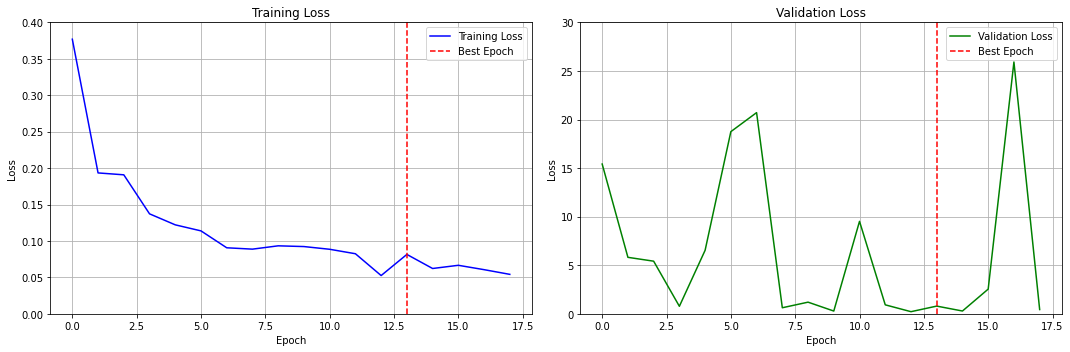

In [35]:
plt.figure(figsize=(15, 5))

# Training Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.axvline(x=13, color='r', linestyle='--', label='Best Epoch')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.4)  # Training Loss의 범위에 맞게 조정
plt.grid(True)
plt.legend()

# Validation Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], 'g-', label='Validation Loss')
plt.axvline(x=13, color='r', linestyle='--', label='Best Epoch')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 30)  # Validation Loss의 범위에 맞게 조정
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 클래스 가중치 영향 : train_loss 안정화
클래스 가중치를 통해 현저한 변화를 보인 부분은 traing loss의 안정적 하락이었다.  
기존 데이터에서 NORMAL(적은 데이터)에 대한 학습량이 가중치로 개선되어 나타난 효과라 본다.
그러나, 여전히 검증 단계에서는 심한 변동성을 보이며 일반화 과정이 되고 있지 않다.   

베이스모델과 동일하게 '고정된 Recall과 아직 개선되지 않은 precision' 은 분류 성능이 드러나고 있지 않은 상황.

train_acc대비 현저히 낮은 val_acc의 갭도 과적합 상태로 해석될 수 있다. 
그리고 생각해보건데 클래스 불균형은 비교하기전에 선제적으로 설정해도 무방하다. 
뷸균형 상태에서 어느정도 학습이 이뤄져 과적합돼있기 때문이다. 

이제 본격적으로 학습률과 배치사이즈를 튜닝해보고 이어서 정규화로 개선을 시도해보도록 하겠다. 이후, 큰 개선점이 없다면 데이터 증강을 시행한다. 



### 4-3 학습률과 배치 사이즈 조정
보통 이 둘의 연관성이 있어 함께 조율해 좋다고 한다. 순차적으로 해보기로 한다.

4-3-1. 학습률 기존 0.001에서 0.0001로 조정

In [40]:
# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [41]:
# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
130/130 [==============================] - 65s 420ms/step - loss: 0.0412 - accuracy: 0.7435 - precision: 0.7435 - recall: 1.0000 - val_loss: 0.3270 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 53s 407ms/step - loss: 0.0365 - accuracy: 0.7454 - precision: 0.7454 - recall: 1.0000 - val_loss: 0.2562 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 53s 408ms/step - loss: 0.0286 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 0.1514 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 52s 404ms/step - loss: 0.0276 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.6213 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 55s 424ms/step - loss: 0.0145 - accura

### 학습률 낮춤 효과 : val_loss 안정성 향상
최적 성능 3에폭으로 8에폭에서 정지.   
val_loss가 빠르게 하락했고 안정화되었다.   
이전: 15.4 → 5.8 → 5.4 → 0.77 → 6.5 → 18.7 → 20.7   
현재: 0.32 → 0.25 → 0.15 → 0.62 → 0.23

지금부터는 학습발생마다 결과 저장하고 가겠습니다. 

In [42]:
import pickle
# 현재 history 저장
experiment_name = 'history_lr0001_cw'  # 학습률 0.0001, 클래스 가중치 적용
with open(f'{experiment_name}.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print(f"Current experiment history saved as {experiment_name}.pkl")

Current experiment history saved as history_lr0001_cw.pkl


4-3-2. 배치사이즈 32 -> 64

In [43]:
BATCH_SIZE = 64
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# steps_per_epoch 재계산
steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE
validation_steps = VAL_IMG_COUNT // BATCH_SIZE

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
65/65 [==============================] - 62s 809ms/step - loss: 0.0135 - accuracy: 0.7435 - precision: 0.7435 - recall: 1.0000 - val_loss: 0.0860 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/20
65/65 [==============================] - 53s 818ms/step - loss: 0.0121 - accuracy: 0.7450 - precision: 0.7450 - recall: 1.0000 - val_loss: 0.1219 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 52s 812ms/step - loss: 0.0081 - accuracy: 0.7450 - precision: 0.7450 - recall: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 52s 808ms/step - loss: 0.0079 - accuracy: 0.7433 - precision: 0.7433 - recall: 1.0000 - val_loss: 0.1126 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 53s 824ms/step - loss: 0.0063 - accuracy: 0.7464

4-3-3. 배치사이즈 64 -> 16

In [44]:
# 배치사이즈 16으로 데이터셋 재구성
BATCH_SIZE = 16
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# steps_per_epoch 재계산
steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE
validation_steps = VAL_IMG_COUNT // BATCH_SIZE

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
261/261 [==============================] - 64s 210ms/step - loss: 0.0424 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 0.1621 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 54s 207ms/step - loss: 0.0323 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 1.1327 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 55s 210ms/step - loss: 0.0239 - accuracy: 0.7455 - precision: 0.7455 - recall: 1.0000 - val_loss: 0.9371 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 55s 209ms/step - loss: 0.0208 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 0.6708 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 5/20
261/261 [==============================] - 57s 221ms/step - loss: 0.0187 - accura

### 배치사이즈에 따른 변화는 미미
배치사이즈 변경 (32 → 64 → 16)
성능에 큰 영향 없음
recall=1.0 문제 지속

### 다른 차원으로 넘어가야 할 시점
모든 예측을 한쪽으로 하고 있고 실질적인 분류 이루어지지 않음.
시도할 사항.
1. 클래스 가중치 재조정
2. 정규화 적용(Dropout)
3. Cross-validation 적용

### 4-4. 클래스 가중치 재조정
폐렴의 가중치는 감소시키고 정상은 증가시켜 학습시켜 폐렴 쏠림현상 비교  
(실험속도를 좀더 올리기 위해 Lr=0.0005 Batch=128 로 설정)

In [47]:
BATCH_SIZE = 128
learning_rate = 0.0005

# 데이터셋 재구성
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# steps 재계산
steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE
validation_steps = VAL_IMG_COUNT // BATCH_SIZE
# 새로운 가중치 설정
new_weight_for_0 = weight_for_0 * 1.2    # NORMAL 가중치 증가
new_weight_for_1 = weight_for_1 * 0.8    # PNEUMONIA 가중치 감소

class_weight = {0: new_weight_for_0,1: new_weight_for_1}

print(f"New Weight for class 0 (Normal): {new_weight_for_0:.2f}")
print(f"New Weight for class 1 (Pneumonia): {new_weight_for_1:.2f}")

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

New Weight for class 0 (Normal): 2.35
New Weight for class 1 (Pneumonia): 0.54
Epoch 1/20
32/32 [==============================] - 63s 2s/step - loss: 0.0194 - accuracy: 0.7441 - precision: 0.7441 - recall: 1.0000 - val_loss: 0.0973 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/20
32/32 [==============================] - 50s 2s/step - loss: 0.0112 - accuracy: 0.7473 - precision: 0.7473 - recall: 1.0000 - val_loss: 0.1049 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/20
32/32 [==============================] - 51s 2s/step - loss: 0.0088 - accuracy: 0.7432 - precision: 0.7432 - recall: 1.0000 - val_loss: 0.1109 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/20
32/32 [==============================] - 52s 2s/step - loss: 0.0065 - accuracy: 0.7437 - precision: 0.7437 - recall: 1.0000 - val_loss: 0.1087 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/20
32/32 [===============

### 클래스 가중치를 재조정 해도 영향력은 크지 않음. 보다 더 구조적 변화필요

### 4-5. Dropout Layer 추가
폐렴의 가중치는 감소시키고 정상은 증가시켜 학습시켜 폐렴 쏠림현상 비교  
(실험속도를 좀더 올리기 위해 Lr=0.0005 Batch=128 로 설정)

In [50]:
def build_model(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # conv1: 7×7, 64
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # 첫 번째 conv 이후
    
    # 3×3 max pool
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # conv2_x: [3×3, 64]×2
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = tf.keras.layers.Dropout(0.2)(x)  # conv2_x 블록 이후
    
    # conv3_x: [3×3, 128]×2
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)
    x = tf.keras.layers.Dropout(0.3)(x)  # conv3_x 블록 이후
    
    # conv4_x: [3×3, 256]×2
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)
    x = tf.keras.layers.Dropout(0.3)(x)  # conv4_x 블록 이후
    
    # conv5_x: [3×3, 512]×2
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512)
    x = tf.keras.layers.Dropout(0.4)(x)  # conv5_x 블록 이후
    
    # 7×7 average pool
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layers (2×1000)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # 첫 번째 Dense 이후
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # 두 번째 Dense 이후
    
    # Output Layer
    outputs = tf.keras.layers.Dense(1, activation='softmax')(x)  # binary classification이므로 sigmoid로 변경
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [52]:
# 모델 생성
model = build_model(input_shape=(180, 180, 3)) 

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
32/32 [==============================] - 66s 2s/step - loss: 0.3033 - accuracy: 0.7461 - precision_3: 0.7461 - recall_3: 1.0000 - val_loss: 2.3448 - val_accuracy: 0.7324 - val_precision_3: 0.7324 - val_recall_3: 1.0000
Epoch 2/20
32/32 [==============================] - 51s 2s/step - loss: 0.1405 - accuracy: 0.7429 - precision_3: 0.7429 - recall_3: 1.0000 - val_loss: 4.4963 - val_accuracy: 0.7363 - val_precision_3: 0.7363 - val_recall_3: 1.0000
Epoch 3/20
32/32 [==============================] - 52s 2s/step - loss: 0.1359 - accuracy: 0.7444 - precision_3: 0.7444 - recall_3: 1.0000 - val_loss: 5.1707 - val_accuracy: 0.7314 - val_precision_3: 0.7314 - val_recall_3: 1.0000
Epoch 4/20
32/32 [==============================] - 52s 2s/step - loss: 0.1228 - accuracy: 0.7441 - precision_3: 0.7441 - recall_3: 1.0000 - val_loss: 6.8228 - val_accuracy: 0.7334 - val_precision_3: 0.7334 - val_recall_3: 1.0000
Epoch 5/20
32/32 [==============================] - 53s 2s/step - loss: 0.0836 -

#### Dropout을 추가해도 물론 배치사이즈의 큰폭이 있긴했어도 역시 근본적인 문제는 개선이 안되고 오히려 validation loss가 더 불안정해졌다. 
#### 분류의 정확성이라는 근본적인 문제에 직접적이고 시급한 부분은 데이트 증강을 통해 더 다양한 패턴을 학습하는 것이 중요. 
#### 층이 깊고 복잡해도 성능개선의 핵심이 심층성과 무관할 때도 있다.



## 5. 데이터 증강에 따른 성능 비교

### 5-1. 데이터 증강 기법 적용

In [56]:
# 데이터 증강 정의
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),  
    tf.keras.layers.RandomHeight(0.2),            
    tf.keras.layers.RandomWidth(0.2),             
])

In [57]:
# Dropout 이전 버전 모델로 재정의
def build_model(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # 데이터 증강 레이어 추가
    x = data_augmentation(inputs)
    
    # 기존 모델 구조 유지
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512)
    
    # Global Average Pooling and Dense layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model


In [58]:
# 모델 생성 및 컴파일
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
32/32 [==============================] - 85s 2s/step - loss: 0.4203 - accuracy: 0.7463 - precision_4: 0.7463 - recall_4: 1.0000 - val_loss: 3.9424 - val_accuracy: 0.7373 - val_precision_4: 0.7373 - val_recall_4: 1.0000
Epoch 2/20
32/32 [==============================] - 58s 2s/step - loss: 0.2681 - accuracy: 0.7417 - precision_4: 0.7417 - recall_4: 1.0000 - val_loss: 4.0655 - val_accuracy: 0.7324 - val_precision_4: 0.7324 - val_recall_4: 1.0000
Epoch 3/20
32/32 [==============================] - 58s 2s/step - loss: 0.2567 - accuracy: 0.7437 - precision_4: 0.7437 - recall_4: 1.0000 - val_loss: 3.3243 - val_accuracy: 0.7314 - val_precision_4: 0.7314 - val_recall_4: 1.0000
Epoch 4/20
32/32 [==============================] - 59s 2s/step - loss: 0.2496 - accuracy: 0.7493 - precision_4: 0.7493 - recall_4: 1.0000 - val_loss: 2.1739 - val_accuracy: 0.7324 - val_precision_4: 0.7324 - val_recall_4: 1.0000
Epoch 5/20
32/32 [==============================] - 59s 2s/step - loss: 0.2207 -

### 여전히 분류 능력에서 있어 큰 폭의 변화를 주고 있진 못하다. 

### 흉부 X-ray는 특별히 클래스 간 데이터 블균형이 근본적인 문제인 만큼 데이터 증강의 방향을 <데이터의 균형 학습>에 맞추어야 한다는 전제를 세워본다. 

### 5-2. 강화된 데이터 증강과 극단적인 클래스 가중치 적용 시도(마지막)

In [60]:
# 데이터 증강 강화
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.3),        # 0.2 → 0.3
    tf.keras.layers.RandomZoom(0.3),            # 0.2 → 0.3
    tf.keras.layers.RandomTranslation(0.2, 0.2), # 0.1 → 0.2
    tf.keras.layers.RandomHeight(0.2),          # 새로 추가
    tf.keras.layers.RandomWidth(0.2),           # 새로 추가
])

# 극단적인 클래스 가중치
class_weight = {0: 5.0,  # NORMAL 클래스 (소수 클래스)
                1: 0.1   # PNEUMONIA 클래스 (다수 클래스)
}

# 마지막 정밀 실험을 위해 배치 사이즈 최소화
BATCH_SIZE = 16


# 데이터셋 재구성
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# steps 재계산
steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE
validation_steps = VAL_IMG_COUNT // BATCH_SIZE

In [65]:
# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
261/261 [==============================] - 92s 314ms/step - loss: 0.2342 - accuracy: 0.7445 - precision_4: 0.7445 - recall_4: 1.0000 - val_loss: 0.4707 - val_accuracy: 0.7337 - val_precision_4: 0.7337 - val_recall_4: 1.0000
Epoch 2/20
261/261 [==============================] - 61s 236ms/step - loss: 0.1618 - accuracy: 0.7438 - precision_4: 0.7438 - recall_4: 1.0000 - val_loss: 2.0117 - val_accuracy: 0.7337 - val_precision_4: 0.7337 - val_recall_4: 1.0000
Epoch 3/20
261/261 [==============================] - 61s 236ms/step - loss: 0.2108 - accuracy: 0.7443 - precision_4: 0.7443 - recall_4: 1.0000 - val_loss: 4.0073 - val_accuracy: 0.7337 - val_precision_4: 0.7337 - val_recall_4: 1.0000
Epoch 4/20
261/261 [==============================] - 63s 243ms/step - loss: 0.2184 - accuracy: 0.7455 - precision_4: 0.7455 - recall_4: 1.0000 - val_loss: 0.6812 - val_accuracy: 0.7346 - val_precision_4: 0.7346 - val_recall_4: 1.0000
Epoch 5/20
261/261 [==============================] - 55s 21

### 끝끝내 기대한 변화는 주지 못했다.


## 6. 모델 구조 경량화 + 멀티스케일 기법 + sigmoid (찐마지막)

In [69]:
# 1. multi_scale_block 함수 정의
def multi_scale_block(input_tensor):
    # 다양한 커널 사이즈로 특징 추출
    conv1 = tf.keras.layers.Conv2D(64, 1, padding='same')(input_tensor)
    conv3 = tf.keras.layers.Conv2D(64, 3, padding='same')(input_tensor)
    conv5 = tf.keras.layers.Conv2D(64, 5, padding='same')(input_tensor)
    
    # 특징 결합
    concat = tf.keras.layers.Concatenate()([conv1, conv3, conv5])
    return concat

# 2. 모델 정의
def build_light_multi_scale_model(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # 첫 번째 블록: 기본 특징 추출
    x = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    # 두 번째 블록: 다중 스케일 특징 추출
    x = multi_scale_block(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    # 분류 헤드
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs, outputs)

In [2]:
# 모델 컴파일
model = build_light_multi_scale_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

BATCH_SIZE = 32
EPOCHS = 20

# 데이터셋 재구성
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# steps 재계산
steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE
validation_steps = VAL_IMG_COUNT // BATCH_SIZE

NameError: name 'build_light_multi_scale_model' is not defined

In [ ]:
# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
130/130 [==============================] - 65s 430ms/step - loss: 0.2758 - accuracy: 0.2632 - precision_10: 0.7206 - recall_10: 0.0158 - val_loss: 0.6452 - val_accuracy: 0.7324 - val_precision_10: 0.7324 - val_recall_10: 1.0000
Epoch 2/20
130/130 [==============================] - 54s 416ms/step - loss: 0.1854 - accuracy: 0.3050 - precision_10: 0.9953 - recall_10: 0.0686 - val_loss: 0.5710 - val_accuracy: 0.7324 - val_precision_10: 0.7324 - val_recall_10: 1.0000
Epoch 3/20
130/130 [==============================] - 55s 425ms/step - loss: 0.1622 - accuracy: 0.4483 - precision_10: 0.9975 - recall_10: 0.2606 - val_loss: 0.5776 - val_accuracy: 0.7295 - val_precision_10: 0.7295 - val_recall_10: 1.0000
Epoch 4/20
130/130 [==============================] - 54s 422ms/step - loss: 0.1452 - accuracy: 0.5570 - precision_10: 0.9968 - recall_10: 0.4035 - val_loss: 0.3935 - val_accuracy: 0.8828 - val_precision_10: 0.9112 - val_recall_10: 0.9307
Epoch 5/20
130/130 [========================

In [1]:
# 그래프 스타일 설정
plt.style.use('seaborn')

# Figure 1: Validation Precision-Recall 변화 추이
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_precision_5'], 'b-', label='Validation Precision', linewidth=2)
plt.plot(history.history['val_recall_5'], 'r-', label='Validation Recall', linewidth=2)
plt.title('Validation Precision-Recall Curves', fontsize=15, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim([0.0, 1.0])  # y축 범위 설정

# 최고 성능 지점 표시
best_epoch_acc = 5  # 최고 Accuracy 달성 epoch
plt.axvline(x=best_epoch_acc, color='gray', linestyle='--', alpha=0.5)
plt.text(best_epoch_acc+0.1, 0.95, f'Best Accuracy\nEpoch {best_epoch_acc}\nAcc: 88.28%', 
         fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

# Figure 2: Validation Accuracy 변화 추이
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy', linewidth=2)
plt.title('Validation Accuracy Progress', fontsize=15, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim([0.2, 1.0])  # y축 범위 설정

# 최고 성능 지점 표시
plt.axhline(y=0.8828, color='r', linestyle='--', alpha=0.5)
plt.text(0, 0.89, 'Best Accuracy: 88.28%', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# 모델 경량화와 멀티 스케일 기법에서 놀라운 유의미한 성능 개선을 보였다!!!!!

### - 분류성능이 작동했고 이제 recall 값을 개선하는 방향의 튜닝이 이루어지면 되는 단계를 맞이했다고 생각하는 찰나,  
### - Epoch을 거듭하면서 급격히 recall이 개선되며 precision과 균형잡힌 값으로 변하는 퍼포먼스를 눈으로 볼 수 있었다. 
### - 특히 epoch 5에서 dramatic한 개선을 보여줌
### - val_acc 88%까지 상승
### - recall 기준으로 99% 이상 달성
### - 이 찐마지막 시도가 값진 경험이었다!

#### 성능 평가 요약  
1. Validation Accuracy 기준 최고 성능 (Epoch 5)  
Validation Accuracy: 0.8828 (88.28%) 👈 Best  
Validation Precision: 0.9390 (93.90%)  
Validation Recall: 0.8991 (89.91%)  

2. Validation Recall 기준 최고 성능 (Epoch 10)  
Validation Accuracy: 0.7793 (77.93%)  
Validation Precision: 0.7730 (77.30%)  
Validation Recall: 0.9921 (99.21%) 👈 Best  

#### 주요 성과  
Recall=1.0 문제 해결  
Precision과 Recall의 균형 달성  
안정적인 validation accuracy 달성  

#### 개선점  
일부 epoch에서의 성능 불안정성  
Validation loss의 변동성

#### 성공 요인 분석
1. 모델 경량화의 효과
- 과적합 감소
- 더 안정적인 학습
2. 멀티 스케일 기법의 영향
- 다양한 크기의 특징 포착
- 폐렴 패턴의 효과적인 학습
- Epoch 4-5에서 breakthrough 발생

#### 향후 개선 방향
- Epoch 8, 11에서 성능 급락 현상 개선 필요
- 더 안정적인 학습을 위한 learning rate 조정 여지

#### 결론 
- 의료 이미지 분류에서 더 단순하고 효과적인 접근이 때로는 더 좋은 결과를 가져올 수 있다는 것을 보여주는 좋은 사례를 스스로 찾은 듯

### 의료 이미지에서 멀티스케일 기법의 이점
1. 병변 크기 다양성 대응
작은 결절
중간 크기의 염증
큰 영역의 폐렴 패턴
2. 해부학적 구조의 계층적 이해
미세 혈관 구조
기관지 패턴
전체 폐 영역
3. 성능 향상 메커니즘
풍부한 특징 표현
3가지 스케일의 특징이 concatenate되어 192개 채널(643)의 풍부한 특징 맵 생성
모델의 표현력 향상 : 다양한 관점에서의 정보를 동시에 학습
4. 단점 및 한계
파라미터 수 증가
계산 복잡도 상승
메모리 사용량 증가

# summary

1. 초기 모델 성능 개선 시도
학습률 조정 (0.001 → 0.0001)  
배치사이즈 실험 (32 → 64 → 128 → 16)  
recall=1.0 문제 지속
  
2. 클래스 불균형 해소 시도  
의외로 직접적 영향을 끼치지 못했음

3. Dropout 등 정규화 시도  
다양한 레이어에 Dropout 추가  
validation loss 불안정성 증가  
근본적인 문제 해결 실패

4. 데이터 증강 시도  
RandomFlip, RandomRotation, RandomZoom 등 적용   
증강 강도 점진적 증가 (0.2 → 0.3)  
추가적인 증강 기법 도입  
추가 클래스 불균형 해결 시도  
클래스 가중치 극단적 조정 (5.0 vs 0.1)  
데이터 증강과 병행  

5. 모델아키텍쳐 경량화(전혀 다른 모델 적용)+멀티 스케일 기법 도입
유의미한 변화를 주었다.
ResNet-18이 절대 최적이 아님을 확인할 수 있는 단계

6. 가설 설정
심층망이 성능 개선을 저해할 모델의 태생적 구조가 있을 수 있다.


#### 결론
- ResNet-18 상에서는 전통적인 데이터 증강과 가중치 조정만으로는 한계가 있음
- 더 고도화되거나 효과적인 접근 방식(예: GAN, 새로운 아키텍처, 스캐닝 기법 등)이 필요함

# Reference

- Data Augmentation Techniques for Deep Learning-Based Medical Image Analyses
https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002651308

- 딥러닝 기반 의료영상 분석을 위한 데이터 증강 기법
https://pmc.ncbi.nlm.nih.gov/articles/PMC9431833/  
김 민규 1, 배 현진 2,✉
Author information
Article notes
Copyright and License information
PMCID: PMC9431833  PMID: 36237718


< 논문 발췌 내용 >  
"Salehinejad 등(21)은 흉부 X-ray 영상에서 정상을 포함한 5가지 질환을 분류하는 연구를 진행하였다. 실험에 사용한 실제 데이터는 정상 환자 15781명, 심비대증 환자 17098명, 흉막 삼출 환자 14510명, 폐부종 환자 5018명, 기흉 환자 4013명의 흉부 X-ray로 클래스 간 데이터 불균형이 심한 것을 알 수 있다. 데이터 불균형이 분류 성능에 끼치는 영향과 GAN으로 증강하여 불균형을 없앤 것이 분류 성능에 끼치는 영향을 연구하기 위해 다음 세 가지 연구를 진행하였다. 첫 번째로 클래스 간 불균형이 있는 데이터를 그대로 학습에 사용하였다. 두 번째는 과소표집(undersampling)을 통해 클래스 간 불균형을 균형 있게 맞춘 데이터를 학습에 사용하였다. 과소표집이란 데이터의 수가 가장 작은 클래스에 맞춰 다른 모든 클래스의 데이터를 동일한 개수로 추출하는 방법이다. 마지막으로, DCGAN을 이용하여 데이터를 증강해 클래스 간 불균형을 균형 있게 맞추어 학습을 하였다. 그 결과 각 질환별 분류 정확도의 평균이 과소표집을 통해 클래스 간 데이터 수의 균형을 맞춘 경우가 가장 낮았고(58.90%), 불균형 데이터를 그대로 학습한 경우가 두 번째(70.87%), 그리고 GAN을 이용해 증강한 경우가 월등히 높은 성능(92.10%)을 보였다. 이 결과를 통해 GAN을 이용해 데이터 수를 증강하고 클래스 간 데이터 수의 균형을 맞추는 것이 분류 성능을 크게 높일 수 있음을 알 수 있다."

< 해당 내용 요점 >  
  
실험 방법:
1. 원본 데이터 그대로 학습 (불균형 상태)
2. 과소표집(Undersampling): 최소 클래스에 맞춰 조정
3. DCGAN 증강: GAN으로 데이터 생성하여 균형 맞춤

실험 결과 (평균 분류 정확도):
1. 과소표집: 58.90% (최저)
2. 원본 데이터: 70.87%
3. GAN 증강: 92.10% (최고)

결론:  
- GAN을 통한 데이터 증강이 가장 효과적
- 단순 과소표집은 오히려 성능 저하
- 데이터 불균형 해소가 분류 성능 향상에 중요

### GAN 기반 데이터 증강 기법
GAN은 비지도학습(unsupervised learning) 방식의 인공지능 알고리즘 중 하나로 입력 데이터의 특징을 스스로 학습하여 새로운 데이터를 생성해내는 기법이다(11). GAN의 학습 과정에는 영상을 생성하는 생성기(generator)와 생성된 영상과 실제 영상을 판별하는 판별기(discriminator)가 사용된다(Fig. 2). 학습의 시작에 생성기는 무작위 노이즈를 초기값으로 입력받아, 생성기 네트워크를 통과시켜 영상을 생성해 낸다. 판별기는 입력 영상의 특징들을 학습하여 실제 영상과 합성 영상을 판별한 뒤, 생성기 네트워크를 업데이트한다. 이렇게 생성, 판별 및 피드백, 모델 수정 과정을 반복하여 학습이 끝나면, 학습된 생성기만 떼어내어 임의의 잠재 벡터(altent vector)에 대해 새로운 합성 영상을 만들 수 있게 된다. 이렇게 만든 합성 영상을 통해 학습 데이터 증강이 가능하다(14).

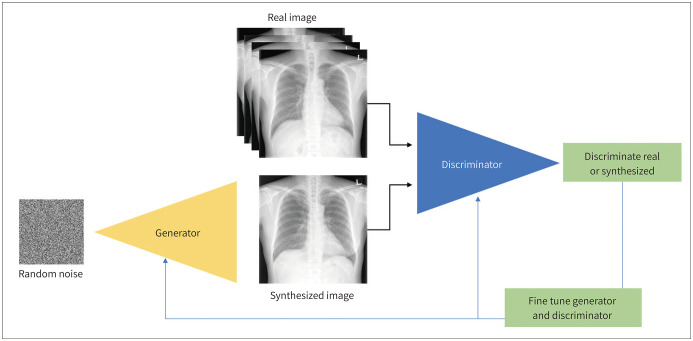

To. 10기의 아버지 웅제퍼실님께

날이 밝아올거 같네요. 밤새웠습니다.퍼실님^^. 
첨에 포기하고 싶은 마음까지 들었다가 무모하지만 여기 다 담아내지 못한 노력들로 어느 순간 오기가 생겼습니다. 딥러닝에 많이 다가간 기분이 들어 보람을 갖습니다. 
조금씩 딥러닝의 차가움에 지쳐갈즈음 다시금 생기를 찾았습니다. 
아무쪼록 육아와 병행하는 가운데 선처를 구합니다... 흑흑
늘 감사합니다. 

어제 프로젝트 53% 이상 못 보여드려서 오늘 꼭 보여드리고 싶었습니다.